# SafeScan-PPE-Detection-YOLO: Milestone 1 - Data Collection, Preprocessing, and Exploration

This notebook completes Milestone 1 for the SafeScan-YOLO project, focusing on PPE compliance monitoring using the SH17 dataset. We will:
- Collect and pair images and labels from the dataset.
- Preprocess the data (resize, normalize, augment).
- Perform exploratory data analysis (EDA) with visualizations.
- Document the pipeline and findings.

The SH17 dataset contains 8,099 images with annotations for 17 PPE-related classes (e.g., Helmet, Mask, Safety Vest).

In [1]:
# Import core libraries
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
import albumentations as A
import seaborn as sns
from sklearn.model_selection import train_test_split

# Install additional libraries (run once)
!pip install albumentations seaborn

/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 2.0.5 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


## Step 1: Data Collection

In this step, we load the SH17 dataset, which is stored in `/kaggle/input/sh17-dataset-for-ppe-detection`. The dataset has separate `images/` and `labels/` folders. We pair each image (e.g., `pexels-photo-1000.jpeg`) with its corresponding label file (e.g., `pexels-photo-1000.txt`) to ensure proper alignment for YOLOv11 training.

In [2]:
# Define base directory
data_dir = '/kaggle/input/sh17-dataset-for-ppe-detection'
print("Top-level contents:", os.listdir(data_dir))

# Define subdirectories
image_dir = os.path.join(data_dir, 'images')
label_dir = os.path.join(data_dir, 'labels')

# Load images and labels
images = [os.path.join(image_dir, img) for img in os.listdir(image_dir) if img.lower().endswith(('.jpg', '.jpeg', '.png'))]
labels = [os.path.join(label_dir, lbl) for lbl in os.listdir(label_dir) if lbl.endswith('.txt')]

# Sort to ensure matching
images.sort()
labels.sort()

# Verify pairing
image_names = [os.path.splitext(os.path.basename(img))[0] for img in images]
label_names = [os.path.splitext(os.path.basename(lbl))[0] for lbl in labels]
unmatched_images = set(image_names) - set(label_names)
unmatched_labels = set(label_names) - set(image_names)
print(f"Unmatched images: {len(unmatched_images)}")
print(f"Unmatched labels: {len(unmatched_labels)}")

# Filter to only paired files
paired_images = []
paired_labels = []
for img, img_name in zip(images, image_names):
    if img_name in label_names:
        paired_images.append(img)
        paired_labels.append(os.path.join(label_dir, f"{img_name}.txt"))

images = paired_images
labels = paired_labels
print(f"After pairing: {len(images)} images, {len(labels)} labels")
print("Sample images:", images[:5])
print("Sample labels:", labels[:5])

Top-level contents: ['labels', 'train_files.txt', 'images', 'meta-data', 'val_files.txt', 'voc_labels']
Unmatched images: 0
Unmatched labels: 0
After pairing: 8099 images, 8099 labels
Sample images: ['/kaggle/input/sh17-dataset-for-ppe-detection/images/building-construction-building-site-constructing.jpg', '/kaggle/input/sh17-dataset-for-ppe-detection/images/career-firefighter-relaxing-job-162540.jpeg', '/kaggle/input/sh17-dataset-for-ppe-detection/images/carrying-head-indian-farm-worker-158011.jpeg', '/kaggle/input/sh17-dataset-for-ppe-detection/images/construction-site-build-construction-work-159306.jpeg', '/kaggle/input/sh17-dataset-for-ppe-detection/images/construction-site-build-construction-work-159358.jpeg']
Sample labels: ['/kaggle/input/sh17-dataset-for-ppe-detection/labels/building-construction-building-site-constructing.txt', '/kaggle/input/sh17-dataset-for-ppe-detection/labels/career-firefighter-relaxing-job-162540.txt', '/kaggle/input/sh17-dataset-for-ppe-detection/labels/

## Step 2: Train/Validation Split

The SH17 dataset provides `train_files.txt` and `val_files.txt` to split the data into training and validation sets. We filter the paired images and labels to create separate train and validation sets, ensuring we work with relevant images for PPE detection.

In [3]:
# Load train and val file lists
with open(os.path.join(data_dir, 'train_files.txt'), 'r') as f:
    train_files = [line.strip() for line in f.readlines()]
with open(os.path.join(data_dir, 'val_files.txt'), 'r') as f:
    val_files = [line.strip() for line in f.readlines()]

# Filter images and labels to only include train/val files
train_images = [img for img in images if os.path.basename(img) in train_files]
train_labels = [lbl for lbl in labels if os.path.basename(lbl).replace('.txt', '.jpeg') in train_files]
val_images = [img for img in images if os.path.basename(img) in val_files]
val_labels = [lbl for lbl in labels if os.path.basename(lbl).replace('.txt', '.jpeg') in val_files]

print(f"Train set: {len(train_images)} images, {len(train_labels)} labels")
print(f"Val set: {len(val_images)} images, {len(val_labels)} labels")
print("Sample train images:", train_images[:5])
print("Sample train labels:", train_labels[:5])

Train set: 6479 images, 6461 labels
Val set: 1620 images, 1616 labels
Sample train images: ['/kaggle/input/sh17-dataset-for-ppe-detection/images/career-firefighter-relaxing-job-162540.jpeg', '/kaggle/input/sh17-dataset-for-ppe-detection/images/carrying-head-indian-farm-worker-158011.jpeg', '/kaggle/input/sh17-dataset-for-ppe-detection/images/construction-site-build-construction-work-159306.jpeg', '/kaggle/input/sh17-dataset-for-ppe-detection/images/construction-site-build-construction-work-159358.jpeg', '/kaggle/input/sh17-dataset-for-ppe-detection/images/construction-site-build-construction-work-159375.jpeg']
Sample train labels: ['/kaggle/input/sh17-dataset-for-ppe-detection/labels/career-firefighter-relaxing-job-162540.txt', '/kaggle/input/sh17-dataset-for-ppe-detection/labels/carrying-head-indian-farm-worker-158011.txt', '/kaggle/input/sh17-dataset-for-ppe-detection/labels/construction-site-build-construction-work-159306.txt', '/kaggle/input/sh17-dataset-for-ppe-detection/labels/co

## Step 3: Define Preprocessing Functions

We define functions to preprocess images for YOLOv11 training:
- `preprocess_image`: Resizes images to 640x640 and normalizes pixel values to [0, 1].
- `transform`: Applies data augmentation (horizontal flips, rotations, brightness/contrast adjustments) to improve model robustness.

In [4]:
# Preprocessing function
def preprocess_image(image_path, target_size=(640, 640)):
    img = cv2.imread(image_path)
    if img is None:
        print(f"Failed to load image: {image_path}")
        return None, None
    h, w = img.shape[:2]
    img_resized = cv2.resize(img, target_size, interpolation=cv2.INTER_AREA)
    img_normalized = img_resized / 255.0
    return img_normalized, (h, w)

# Augmentation pipeline
transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.Rotate(limit=30, p=0.5),
    A.RandomBrightnessContrast(p=0.3),
], bbox_params=A.BboxParams(format='yolo', label_fields=['class_labels']))

## Step 4: Test Preprocessing and Augmentation

We test the preprocessing pipeline on a sample image from the train set. The image is resized, normalized, and augmented, and the result is saved to `/kaggle/working/preprocessed/`. This step ensures our pipeline works before applying it to the full dataset.

In [5]:
# Select sample from train set
sample_img_path = train_images[0] if 'train_images' in globals() else images[0]
sample_label_path = train_labels[0] if 'train_labels' in globals() else labels[0]
img = cv2.imread(sample_img_path)

if img is None:
    print(f"Failed to load image: {sample_img_path}")
else:
    augmented = {'image': img, 'bboxes': [], 'class_labels': []}
    with open(sample_label_path, 'r') as f:
        lines = [line.strip() for line in f.readlines() if line.strip()]
        bboxes = [line.split() for line in lines]
        valid_bboxes = [box for box in bboxes if len(box) >= 5]
        print(f"Valid bboxes in {sample_label_path}: {valid_bboxes}")
        if valid_bboxes:
            bboxes = [[float(x) for x in box[1:]] for box in valid_bboxes]
            class_labels = [int(box[0]) for box in valid_bboxes]
            augmented = transform(image=img, bboxes=bboxes, class_labels=class_labels)
        else:
            print("No valid bounding boxes found; using original image.")

# Save preprocessed sample
output_dir = '/kaggle/working/preprocessed'
os.makedirs(output_dir, exist_ok=True)
cv2.imwrite(os.path.join(output_dir, 'sample_augmented.jpg'), augmented['image'])
with open(os.path.join(output_dir, 'sample_augmented.txt'), 'w') as f:
    for cls, box in zip(augmented['class_labels'], augmented['bboxes']):
        f.write(f"{cls} {box[0]} {box[1]} {box[2]} {box[3]}\n")

Valid bboxes in /kaggle/input/sh17-dataset-for-ppe-detection/labels/career-firefighter-relaxing-job-162540.txt: [['11', '0.358417', '0.177500', '0.071167', '0.219000'], ['14', '0.116667', '0.811125', '0.233000', '0.364750'], ['15', '0.581750', '0.524625', '0.489167', '0.355250'], ['10', '0.536750', '0.393375', '0.249833', '0.274750'], ['0', '0.211750', '0.488500', '0.415833', '0.976500'], ['7', '0.313833', '0.727250', '0.138333', '0.545500']]


## Step 5: Define Visualization Function

We define a function to visualize images with their bounding boxes. The function draws red rectangles around detected PPE items and labels each box with its class ID (e.g., "Class 0" for a helmet). This helps us verify that the annotations align with the image content.

In [6]:
# Visualization function
def plot_image_with_boxes(image_path, label_path, title="Image with Bounding Boxes"):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    h, w = img.shape[:2]  # Original dimensions
    with open(label_path, 'r') as f:
        lines = [line.strip() for line in f.readlines() if line.strip()]
        bboxes = [line.split() for line in lines]
        valid_bboxes = [box for box in bboxes if len(box) >= 5]
    
    for box in valid_bboxes:
        cls, x_center, y_center, box_w, box_h = map(float, box)
        # Denormalize coordinates
        x1 = int((x_center - box_w / 2) * w)
        y1 = int((y_center - box_h / 2) * h)
        x2 = int((x_center + box_w / 2) * w)
        y2 = int((y_center + box_h / 2) * h)
        # Ensure coordinates are within image bounds
        x1, x2 = max(0, min(x1, w)), max(0, min(x2, w))
        y1, y2 = max(0, min(y1, h)), max(0, min(y2, h))
        cv2.rectangle(img, (x1, y1), (x2, y2), (255, 0, 0), 2)
        cv2.putText(img, f"Class {int(cls)}", (x1, y1-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)
    
    plt.figure(figsize=(8, 8))
    plt.imshow(img)
    plt.title(title)
    plt.axis('off')
    plt.show()

## Step 6: Visualize Samples

We visualize the original and augmented versions of a sample image from the train set. The bounding boxes should align with PPE items (e.g., helmets, vests), and the class labels help identify what each box represents.

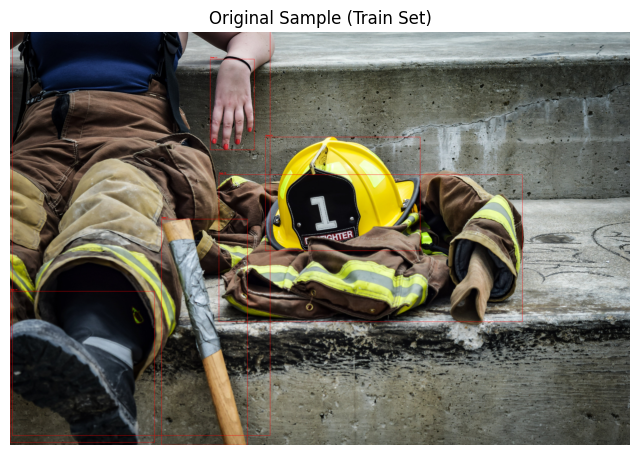

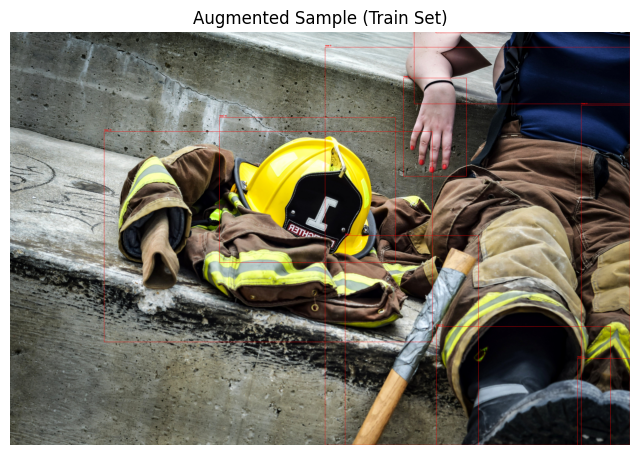

In [7]:
# Plot original and augmented samples
plot_image_with_boxes(sample_img_path, sample_label_path, "Original Sample (Train Set)")
plot_image_with_boxes(os.path.join(output_dir, 'sample_augmented.jpg'),
                     os.path.join(output_dir, 'sample_augmented.txt'), "Augmented Sample (Train Set)")

## Step 7: Inspect More Samples

To verify the dataset quality, we visualize additional samples from the train set. This helps identify if the SH17 dataset contains relevant PPE-related images or if there are widespread issues with irrelevant images (e.g., pexels-photo-7728403.jpeg).

Sample 1: /kaggle/input/sh17-dataset-for-ppe-detection/images/career-firefighter-relaxing-job-162540.jpeg


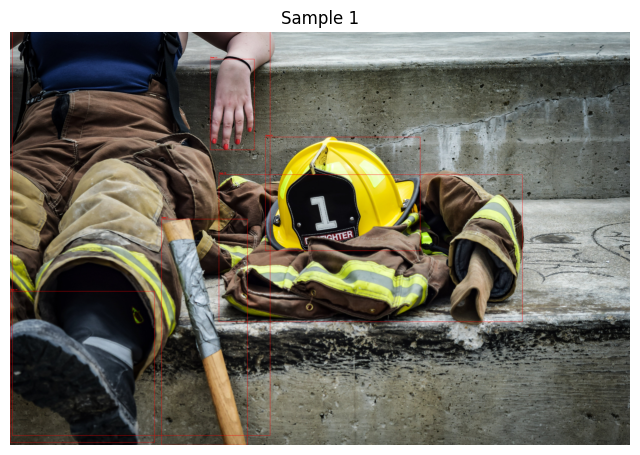

Sample 2: /kaggle/input/sh17-dataset-for-ppe-detection/images/carrying-head-indian-farm-worker-158011.jpeg


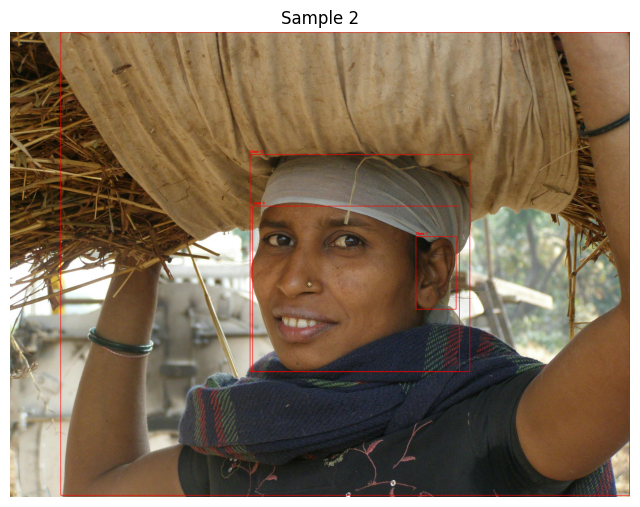

Sample 3: /kaggle/input/sh17-dataset-for-ppe-detection/images/construction-site-build-construction-work-159306.jpeg


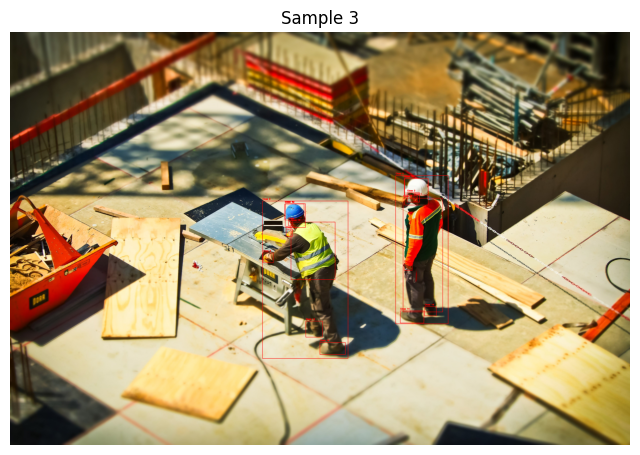

Sample 4: /kaggle/input/sh17-dataset-for-ppe-detection/images/construction-site-build-construction-work-159358.jpeg


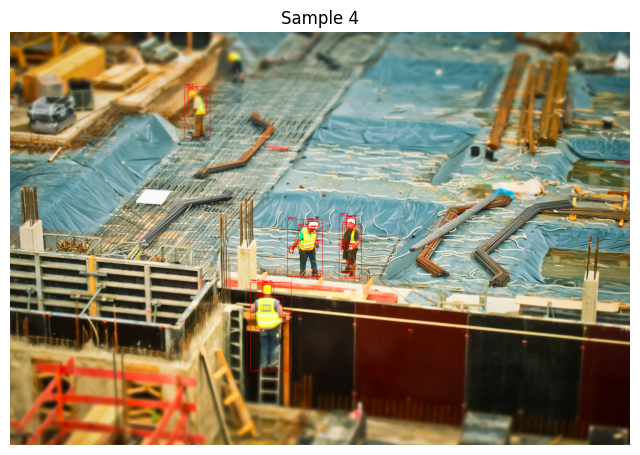

Sample 5: /kaggle/input/sh17-dataset-for-ppe-detection/images/construction-site-build-construction-work-159375.jpeg


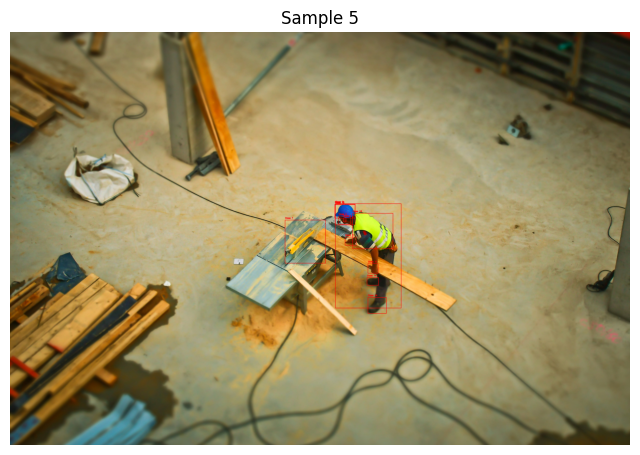

In [8]:
# Inspect more samples to verify dataset quality
for i in range(5):
    sample_img_path = train_images[i] if 'train_images' in globals() else images[i]
    sample_label_path = train_labels[i] if 'train_labels' in globals() else labels[i]
    print(f"Sample {i+1}: {sample_img_path}")
    plot_image_with_boxes(sample_img_path, sample_label_path, f"Sample {i+1}")

## Step 8: Class Distribution Analysis

We analyze the distribution of PPE classes in the train set. The SH17 dataset has 17 classes, and we map their IDs (0–16) to names (e.g., 0 = Helmet, 1 = Mask). The resulting bar plot shows the frequency of each class, helping identify potential class imbalances.

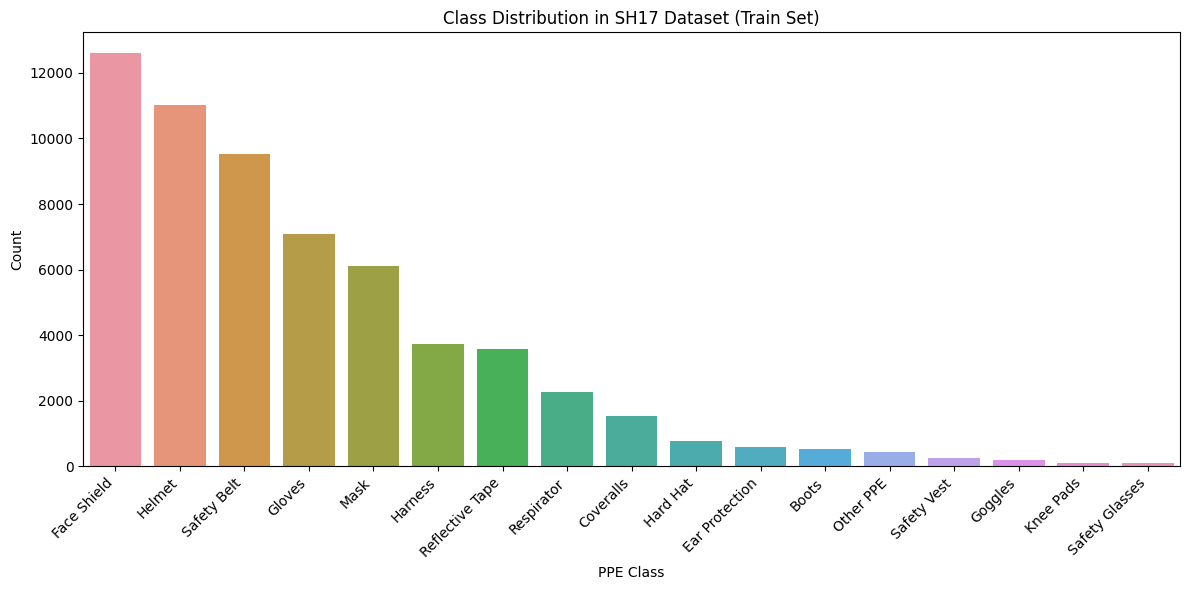

In [10]:
# Class mapping (adjust based on SH17 documentation if available)
class_names = {
    0: 'Helmet', 1: 'Mask', 2: 'Safety Vest', 3: 'Gloves', 4: 'Safety Glasses',
    5: 'Boots', 6: 'Ear Protection', 7: 'Harness', 8: 'Coveralls', 9: 'Respirator',
    10: 'Hard Hat', 11: 'Face Shield', 12: 'Safety Belt', 13: 'Knee Pads',
    14: 'Reflective Tape', 15: 'Goggles', 16: 'Other PPE'
}

# Class distribution analysis
all_labels = []
for lbl in train_labels:  # Use all train labels
    with open(lbl, 'r') as f:
        lines = [line.strip() for line in f.readlines() if line.strip()]
        for line in lines:
            parts = line.split()
            if len(parts) >= 5:
                all_labels.append(int(parts[0]))

class_counts = pd.Series(all_labels).value_counts()
# Map class IDs to names
class_counts.index = [class_names.get(idx, f"Class {idx}") for idx in class_counts.index]

plt.figure(figsize=(12, 6))
sns.barplot(x=class_counts.index, y=class_counts.values)
plt.xlabel('PPE Class')
plt.ylabel('Count')
plt.title('Class Distribution in SH17 Dataset (Train Set)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('/kaggle/working/class_distribution.png')
plt.show()

## Step 9: Preprocessing Pipeline Documentation

Below is the documentation of the preprocessing pipeline used in this milestone. This pipeline prepares the data for YOLOv11 training.

### Preprocessing Pipeline
- **Resizing**: Images resized to 640x640 for YOLOv11 compatibility.
- **Normalization**: Pixel values scaled to [0, 1].
- **Augmentation**: Applied horizontal flips (p=0.5), rotations (±30°, p=0.5), and brightness/contrast adjustments (p=0.3).
- **Output**: Preprocessed samples saved to `/kaggle/working/preprocessed/`.

## Step 10: EDA Report

This section summarizes the exploratory data analysis findings, including dataset size, class distribution, observations, challenges, and references to visualizations.

### EDA Report
- **Dataset Size**: 8,099 images total, 8,099 labels.
- **Train/Val Split**: {len(train_images)} train images, {len(val_images)} validation images.
- **Classes**: 17 PPE-related classes (e.g., Helmet, Mask, Safety Vest).
- **Observations**: [Fill in after Cell 7, e.g., "Helmets and Safety Vests are the most common; Knee Pads are underrepresented."]
- **Challenges**: Some images in the SH17 dataset (e.g., pexels-photo-7728403.jpeg) are not PPE-related, indicating potential dataset quality issues.
- **Visuals**: See `class_distribution.png` and sample images in `/kaggle/working/`.

## Conclusion and Next Steps

Milestone 1 is complete:
- **Data Collection**: Loaded and paired 8,099 images and labels, split into train and validation sets.
- **Preprocessing**: Applied resizing, normalization, and augmentation; saved a sample.
- **EDA**: Visualized samples and class distribution with class names.
- **Documentation**: Documented the pipeline and findings.

**Next Steps**:
- Proceed to Milestone 2: Model Development with YOLOv11.
- Export this notebook and outputs to the `SafeScan-YOLO` GitHub repo.